**Names: Philipp Köhler, Alexander Bespalov**


# Sheet 5

In [2]:
import os
import pandas as pd

## 1 The logistic sigmoid

### (a)
Sigmoid function:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
Derivative of the sigmoid (quotient rule used):
$$
\frac{d}{dx} \sigma(x) = \frac{e^{-x}}{(1 + e^{-x})^2}
$$
Use:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
and
$$
1 - \sigma(x) = \frac{e^{-x}}{1 + e^{-x}}
$$
Thus:
$$
\frac{d}{dx} \sigma(x) = \sigma(x) (1 - \sigma(x))
$$

### (b)

The hyperbolic tangent function is:
$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

The logistic sigmoid function is:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Rewrite $\tanh(x)$ by factoring $e^{-x}$ from numerator and denominator:
$$
\tanh(x) = \frac{1 - e^{-2x}}{1 + e^{-2x}}
$$

From $\sigma(x)$, we can write:
$$
1 - \sigma(x) = \frac{e^{-x}}{1 + e^{-x}}
$$

Thus:
$$
\sigma(x) - (1 - \sigma(x))= 2\sigma(x) - 1 = \frac{2}{1 + e^{-x}} - 1 = \frac{1 - e^{-x}}{1 + e^{-x}}
$$

Observe that $\tanh(x)$ matches $2\sigma(2x) - 1$.

### (c)
The two classes are separated by a line $w^Tx+b$ that goes through the points $x_1 = (1,1.5)$ and $x_2 = (2,2.5)$. The points are chosen because they are in the middle between the datapoints of the two classes. The resulting weights are given by $w = (1,-1)$ and the bias $b=0.5$. Testing those weights on the data gives values below 0 for class 2 and above 0 for class 1 in the argument of the sigmoid. Therefore the activation separates the classes with the given weights.

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [3]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


In [4]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

### (a)

Processing Dataset 1
Dataset 1 Performance: Accuracy=0.99


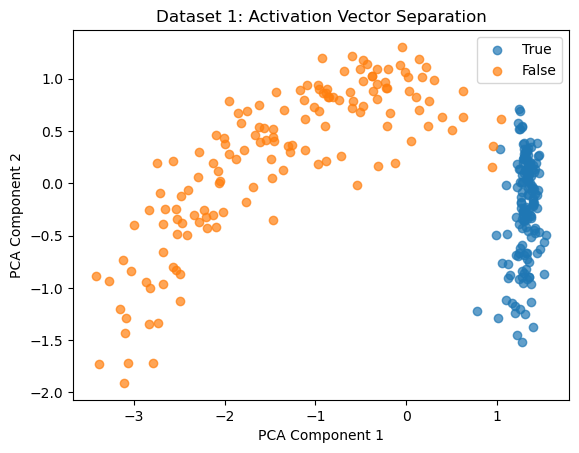

Processing Dataset 2
Dataset 2 Performance: Accuracy=1.00


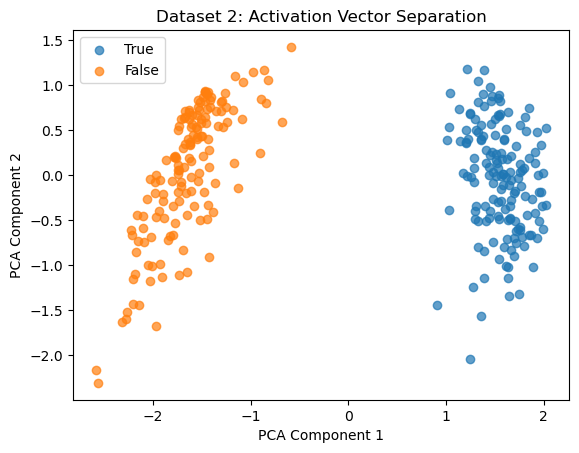

Processing Dataset 3
Dataset 3 Performance: Accuracy=1.00


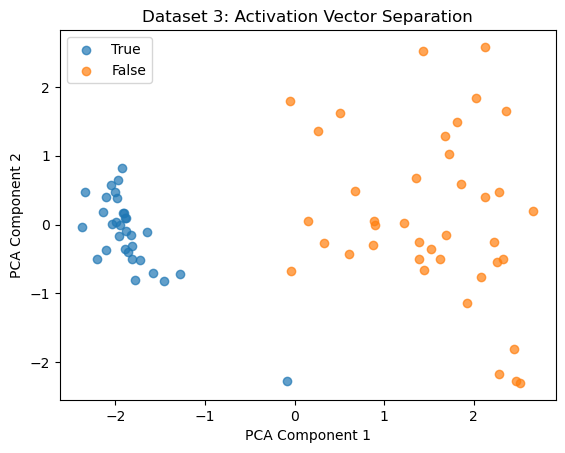

Processing Dataset 4
Dataset 4 Performance: Accuracy=1.00


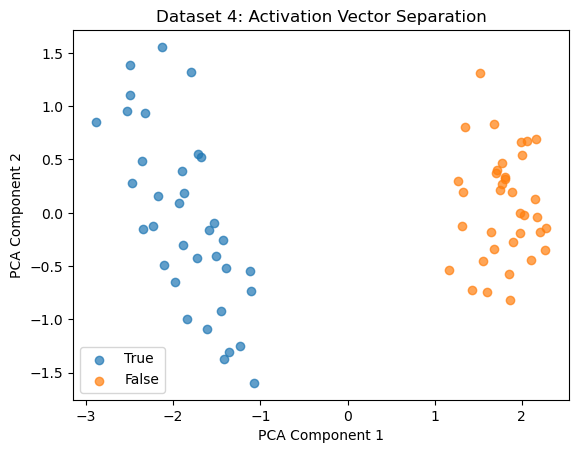

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

accuracies = []

for i, dataset_name in enumerate(dataset_names):
    print(f"Processing Dataset {i + 1}")
    
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    X_train, y_train = dm.get('train') 
    X_test, y_test = dm.get('val')

    clf = LogisticRegression(C=1e12, solver='liblinear')  # No regularization
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append({'Dataset': i + 1, 'Accuracy': accuracy})
    
    print(f"Dataset {i + 1} Performance: Accuracy={accuracy:.2f}")

    activation_vectors = clf.decision_function(X_test).reshape(-1, 1)
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(X_test)
    
    plt.scatter(reduced_features[y_test == 1][:, 0], reduced_features[y_test == 1][:, 1], label='True', alpha=0.7)
    plt.scatter(reduced_features[y_test == 0][:, 0], reduced_features[y_test == 0][:, 1], label='False', alpha=0.7)
    plt.title(f'Dataset {i + 1}: Activation Vector Separation')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

The visualisation of the recuced dimensionality data shows that only dataset 1 in not separable in 2d. The accuracy as it is not 1 shows that the data is also not linearly separable in the original embedding. 

### (b)

In [9]:
dataset_name = dataset_names[0] # choose dataset cities

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
X_train, y_train = dm.get('train') 
X_test, y_test = dm.get('val')

clf_no_reg = LogisticRegression(C=1e12, solver='liblinear')
clf_no_reg.fit(X_train, y_train)

# With regularization (C=1.0 for L2 regularization)
clf_with_reg = LogisticRegression(C=1.0, solver='liblinear')
clf_with_reg.fit(X_train, y_train)

accuracies = []

for dataset_name in dataset_names[1:]:
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    X_train, y_train = dm.get('train') 
    X_test, y_test = dm.get('val')
    
    for model, reg_type in [(clf_no_reg, "No Regularization"), (clf_with_reg, "With Regularization")]:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        accuracies.append({
            "Train Dataset": "cities",
            "Test Dataset": dataset_name,
            "Regularization": reg_type,
            "Accuracy": accuracy
        })

results_df = pd.DataFrame(accuracies)
print(results_df)


  Train Dataset     Test Dataset       Regularization  Accuracy
0        cities       neg_cities    No Regularization  0.510000
1        cities       neg_cities  With Regularization  0.526667
2        cities      sp_en_trans    No Regularization  1.000000
3        cities      sp_en_trans  With Regularization  0.971831
4        cities  neg_sp_en_trans    No Regularization  0.028169
5        cities  neg_sp_en_trans  With Regularization  0.422535


It does not generalize to negated statements, but generalizes well on the translation. Furthermore, the accuracy on neg_ translation is unexpectedly low. It performs much worse than a random classifier. This means that inverting the decision will give a decent classifier again but only in the non regularized case. It is possible that there is a mistake.

### (c)

In [13]:
import torch

dataset_name = dataset_names[0] # choose dataset cities

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
cities_X_train, cities_y_train = dm.get('train') 
cities_X_test, cities_y_test = dm.get('val')

dataset_name = dataset_names[1] # choose dataset neg_cities

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
neg_cities_X_train, neg_cities_y_train = dm.get('train') 
neg_cities_X_test, neg_cities_y_test = dm.get('val')

X_train = torch.cat((cities_X_train, neg_cities_X_train), dim=0)
y_train = torch.cat((cities_y_train, neg_cities_y_train), dim=0)
X_test = torch.cat((cities_X_test, neg_cities_X_test), dim=0)
y_test = torch.cat((cities_y_test, neg_cities_y_test), dim=0)

clf_no_reg = LogisticRegression(C=1e12, solver='liblinear')  # No regularization
clf_no_reg.fit(X_train, y_train)

clf_with_reg = LogisticRegression(C=1.0, solver='liblinear')  # With regularization
clf_with_reg.fit(X_train, y_train)

accuracies = []

for dataset_name in dataset_names[2:]:
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    X_train, y_train = dm.get('train') 
    X_test, y_test = dm.get('val')
    
    for model, reg_type in [(clf_no_reg, "No Regularization"), (clf_with_reg, "With Regularization")]:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        accuracies.append({
            "Train Dataset": "cities + neg_cities",
            "Test Dataset": dataset_name,
            "Regularization": reg_type,
            "Accuracy": accuracy
        })

results_df = pd.DataFrame(accuracies)
print(results_df)

         Train Dataset     Test Dataset       Regularization  Accuracy
0  cities + neg_cities      sp_en_trans    No Regularization  1.000000
1  cities + neg_cities      sp_en_trans  With Regularization  1.000000
2  cities + neg_cities  neg_sp_en_trans    No Regularization  0.971831
3  cities + neg_cities  neg_sp_en_trans  With Regularization  0.971831


The trained classifier works for affirmative and negated statements. As before the generalization to translation is successful, even if the accuracy on the negated dataset is 0.03 lower. Regularization makes no difference in this case.

## 3 Log-sum-exp and soft(arg)max


### (a)

In [17]:
import numpy as np
def lse(vec, lam=1):
    return np.log(np.sum(np.exp(lam * vec)))/lam

def softmax(vec, lam=1):
    return np.exp(lam * vec)/np.sum(np.exp(lam * vec))

sig1 = np.array([1,2,3])
sig2 = sig1 + 10
sig3 = sig1 * 10

sigs = [sig1, sig2, sig3]

for sig in sigs:
    print(f"{sig}: softmax={np.round(softmax(sig), decimals=2)}")

[1 2 3]: softmax=[0.09 0.24 0.67]
[11 12 13]: softmax=[0.09 0.24 0.67]
[10 20 30]: softmax=[0. 0. 1.]


Soft(arg)max is invariant under constant offset and not under rescaling. \
Proof of invariance under constant offset $c$:
$$
\text{soft(arg)max}(c + \sigma) = \frac{\exp(c + \sigma)}{\sum_{j=1}^{K} \exp(c + \sigma_j)} = \frac{\exp(c)}{\exp(c)}\frac{\exp(\sigma)}{\sum_{j=1}^{K} \exp(\sigma_j)} = \frac{\exp(\sigma)}{\sum_{j=1}^{K} \exp(\sigma_j)} = \text{soft(arg)max}(\sigma)
$$

### (b)

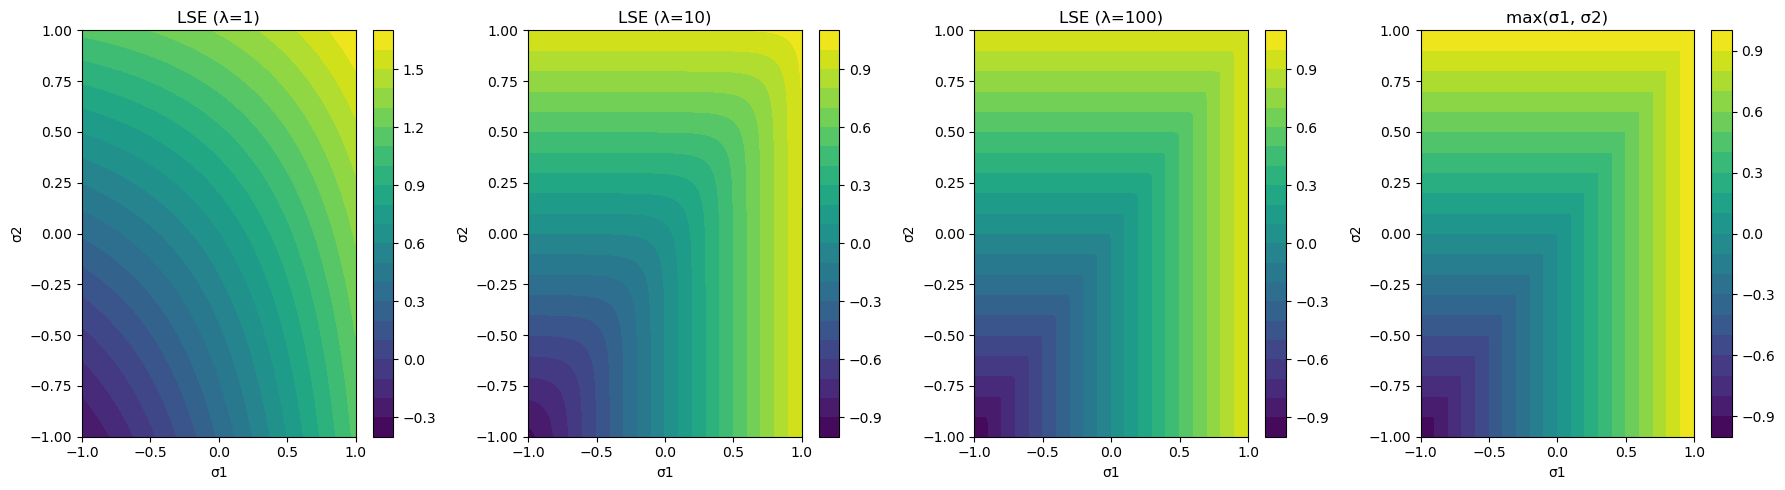

In [18]:
sigma1 = np.linspace(-1, 1, 200)
sigma2 = np.linspace(-1, 1, 200)
sigma1, sigma2 = np.meshgrid(sigma1, sigma2)

lambdas = [1, 10, 100]

def lse(sigma1, sigma2, lam):
    return (1 / lam) * np.log(np.exp(lam * sigma1) + np.exp(lam * sigma2))

max_values = np.maximum(sigma1, sigma2)

fig, axes = plt.subplots(1, len(lambdas) + 1, figsize=(18, 5))
for i, lam in enumerate(lambdas):
    lse_values = lse(sigma1, sigma2, lam)
    ax = axes[i]
    contour = ax.contourf(sigma1, sigma2, lse_values, levels=20, cmap='viridis')
    ax.set_title(f'LSE (λ={lam})')
    ax.set_xlabel('σ1')
    ax.set_ylabel('σ2')
    fig.colorbar(contour, ax=ax)

ax = axes[-1]
contour = ax.contourf(sigma1, sigma2, max_values, levels=20, cmap='viridis')
ax.set_title('max(σ1, σ2)')
ax.set_xlabel('σ1')
ax.set_ylabel('σ2')
fig.colorbar(contour, ax=ax)

plt.tight_layout()
plt.show()

The lse approaches the max function for large $\lambda$.

### (c)

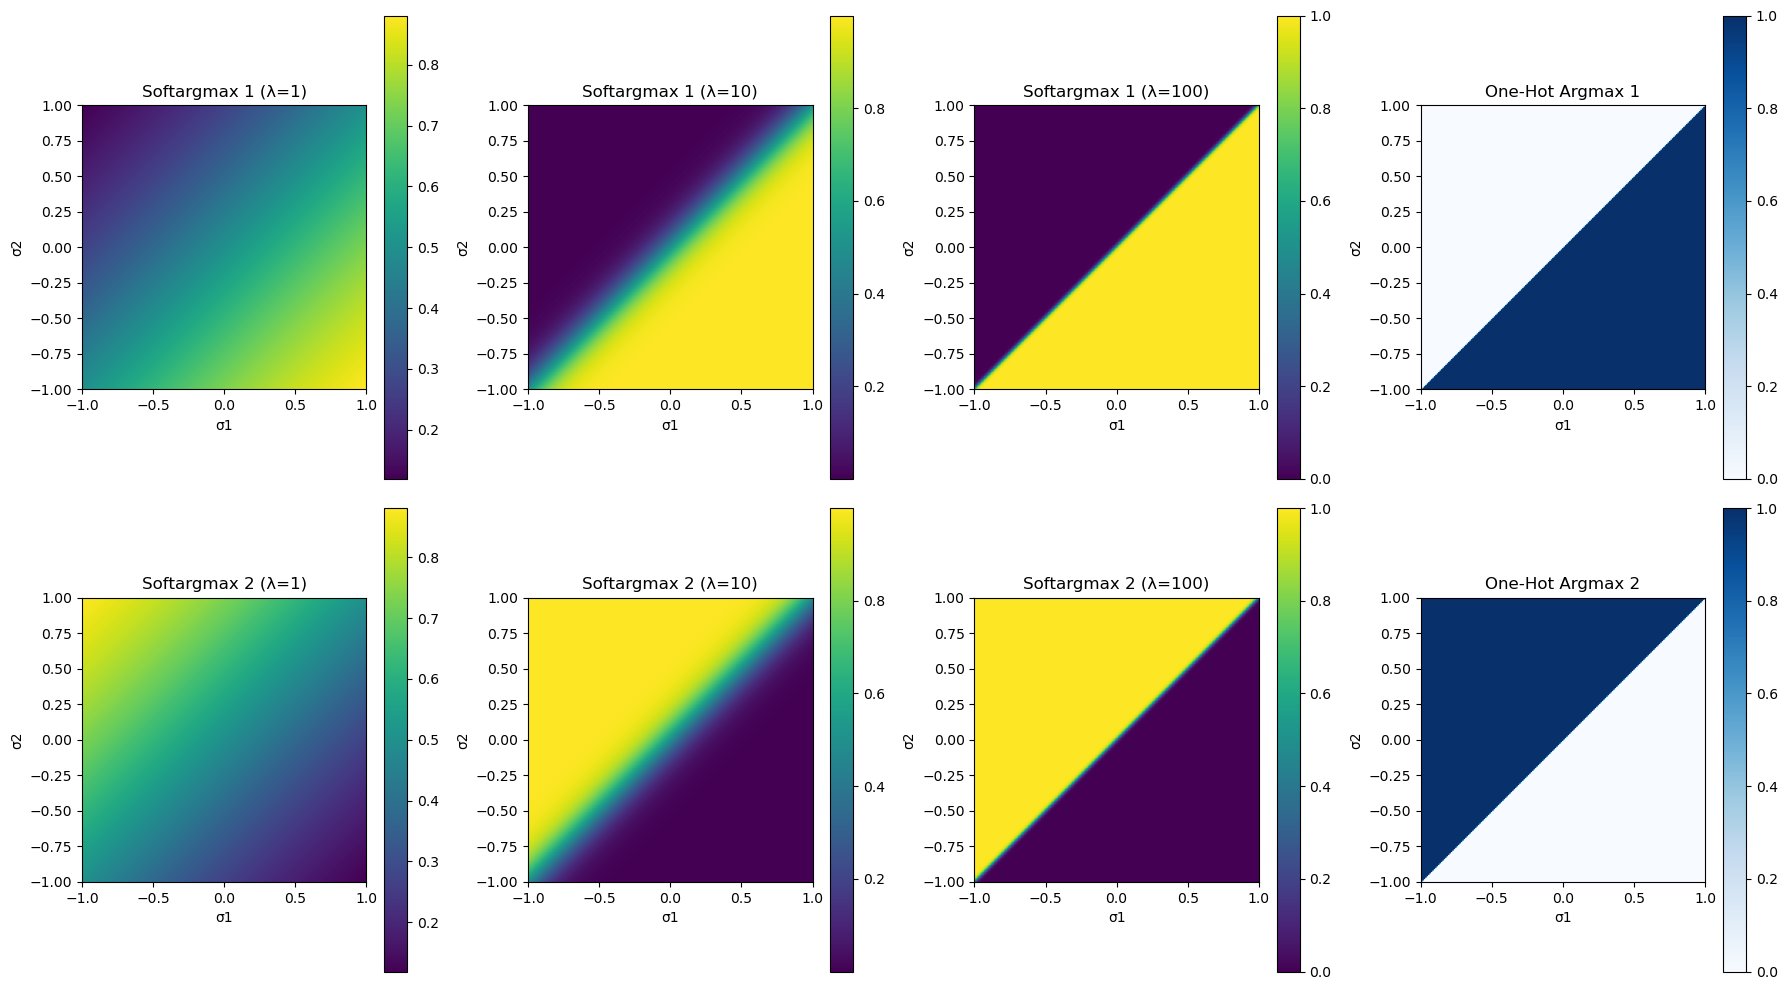

In [19]:
def softargmax_components(sigma1, sigma2, lam):
    exp_sigma1 = np.exp(lam * sigma1)
    exp_sigma2 = np.exp(lam * sigma2)
    softargmax1 = exp_sigma1 / (exp_sigma1 + exp_sigma2)
    softargmax2 = exp_sigma2 / (exp_sigma1 + exp_sigma2)
    return softargmax1, softargmax2

def onehot_argmax(sigma1, sigma2):
    onehot1 = (sigma1 > sigma2).astype(float)  # 1 if σ1 > σ2, else 0
    onehot2 = (sigma2 >= sigma1).astype(float)  # 1 if σ2 ≥ σ1, else 0
    return onehot1, onehot2

fig, axes = plt.subplots(2, len(lambdas) + 1, figsize=(18, 10))

for i, lam in enumerate(lambdas):
    softargmax1, softargmax2 = softargmax_components(sigma1, sigma2, lam)
    
    ax = axes[0, i]
    im = ax.imshow(softargmax1, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    ax.set_title(f'Softargmax 1 (λ={lam})')
    ax.set_xlabel('σ1')
    ax.set_ylabel('σ2')
    fig.colorbar(im, ax=ax)
    
    ax = axes[1, i]
    im = ax.imshow(softargmax2, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    ax.set_title(f'Softargmax 2 (λ={lam})')
    ax.set_xlabel('σ1')
    ax.set_ylabel('σ2')
    fig.colorbar(im, ax=ax)

onehot1, onehot2 = onehot_argmax(sigma1, sigma2)

ax = axes[0, -1]
im = ax.imshow(onehot1, extent=(-1, 1, -1, 1), origin='lower', cmap='Blues', vmin=0, vmax=1)
ax.set_title('One-Hot Argmax 1')
ax.set_xlabel('σ1')
ax.set_ylabel('σ2')
fig.colorbar(im, ax=ax)

ax = axes[1, -1]
im = ax.imshow(onehot2, extent=(-1, 1, -1, 1), origin='lower', cmap='Blues', vmin=0, vmax=1)
ax.set_title('One-Hot Argmax 2')
ax.set_xlabel('σ1')
ax.set_ylabel('σ2')
fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

The softargmax becomes the one-hot argmax for large $\lambda$.

### (d)

LogSumExp:
$$
\text{lse}(\sigma; \lambda) = \frac{1}{\lambda} \log \left( \sum_{i=1}^{k} \exp(\lambda \sigma_i) \right)
$$

The derivative of lse with respect to $ \sigma_j $ is:
$$
\frac{\partial}{\partial \sigma_j} \text{lse}(\sigma) = \frac{1}{\lambda} \cdot \lambda \cdot \frac{\exp(\lambda \sigma_j)}{\sum_{i=1}^{k} \exp(\lambda \sigma_i)}
$$


This derivative is precisely the softargmax for the $ j $-th component:
$$
\frac{\exp(\lambda \sigma_j)}{\sum_{i=1}^{k} \exp(\lambda \sigma_i)}
$$




### (e)

LogSumExp (LSE):

$$
\text{lse}(\sigma; \lambda) = \frac{1}{\lambda} \log \left( \sum_{i=1}^n \exp(\lambda \sigma_i) \right)
$$

As $ \lambda \to \infty $, the exponential terms $ \exp(\lambda \sigma_i) $ grow rapidly. The largest value of $ \sigma_i $ dominates the sum, so:

$$
\sum_{i=1}^n \exp(\lambda \sigma_i) \approx \exp(\lambda \sigma_{\max})
$$

Thus, the LogSumExp simplifies to:

$$
\text{lse}(\sigma; \lambda) \approx \frac{1}{\lambda} \log \left( \exp(\lambda \sigma_{\max}) \right) = \sigma_{\max}
$$

Therefore:

$$
\lim_{\lambda \to \infty} \text{lse}(\sigma; \lambda) = \max(\sigma)
$$





## 4 Linear regions of MLPs

### (a)

Calculate the number of parameters:
$$
(\text{num parameters}(w_1) + \text{num parameters}(b_1)) \cdot \text{num neurons} + \text{num parameters}(w_{out}) + \text{num parameters}(b_{out}) = (2+1)\cdot 20 + 20 +1 = 81
$$

In [ ]:
import torch
import torch.nn as nn

class ShallowNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ShallowNN, self).__init__()
        
        self.hidden = nn.Linear(input_size, hidden_size)  
        self.output = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        x = torch.relu(self.hidden(x)) 
        x = self.output(x) 
        return x

input_size = 2  
hidden_size = 20  
output_size = 1

model = ShallowNN(input_size, hidden_size, output_size)

print(model)

num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

ShallowNN(
  (hidden): Linear(in_features=2, out_features=20, bias=True)
  (output): Linear(in_features=20, out_features=1, bias=True)
)
Number of parameters: 81


### (b)

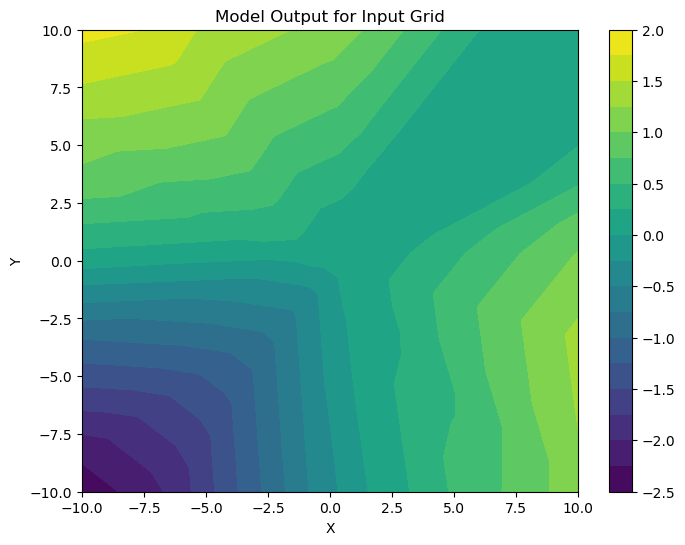

In [73]:
x_range = np.linspace(-10, 10, 500)
y_range = np.linspace(-10, 10, 500)


xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T  # Stack them into 2D input for the model

grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

with torch.no_grad():  # No need to track gradients for this forward pass
    output = model(grid_tensor)

output = output.detach().numpy().reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, output, 20, cmap='viridis')
plt.colorbar()
plt.title('Model Output for Input Grid')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

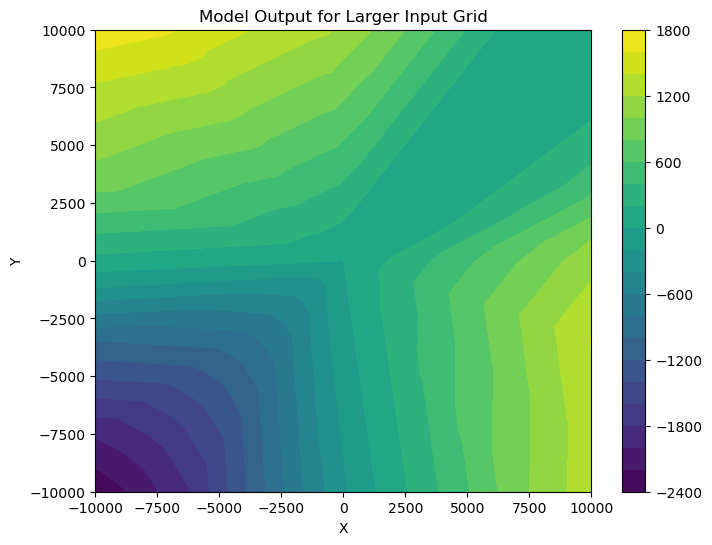

In [74]:
x_range_large = np.linspace(-10000, 10000, 5000) 
y_range_large = np.linspace(-10000, 10000, 5000)

xx_large, yy_large = np.meshgrid(x_range_large, y_range_large)
grid_points_large = np.vstack([xx_large.ravel(), yy_large.ravel()]).T

grid_tensor_large = torch.tensor(grid_points_large, dtype=torch.float32)

with torch.no_grad():
    output_large = model(grid_tensor_large)

output_large = output_large.detach().numpy().reshape(xx_large.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx_large, yy_large, output_large, 20, cmap='viridis')
plt.colorbar()
plt.title('Model Output for Larger Input Grid')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

The structure seems to be captured already in the range of -10 to 10.

### (c)

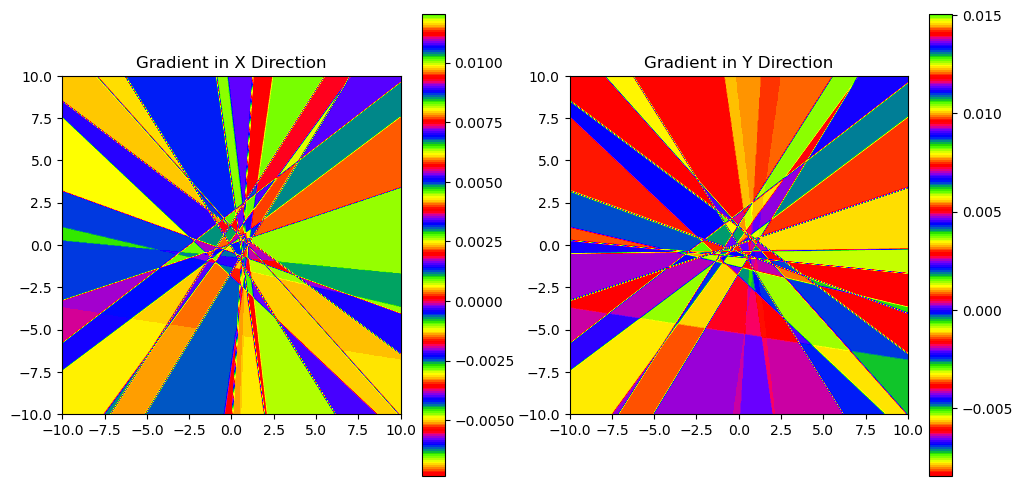

In [75]:
grad_x, grad_y = np.gradient(output, axis=(1, 0))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(grad_x, cmap='prism', extent=[-10, 10, -10, 10])
plt.colorbar()
plt.title('Gradient in X Direction')

plt.subplot(1, 2, 2)
plt.imshow(grad_y, cmap='prism', extent=[-10, 10, -10, 10])
plt.colorbar()
plt.title('Gradient in Y Direction')

plt.show()

Areas whith constant gradients and the sharp changes of the gradients on the boundaries of those can be seen. This is due to the relu activation function as gradients can become zero or one depending on the sign of the activation.

### (d)

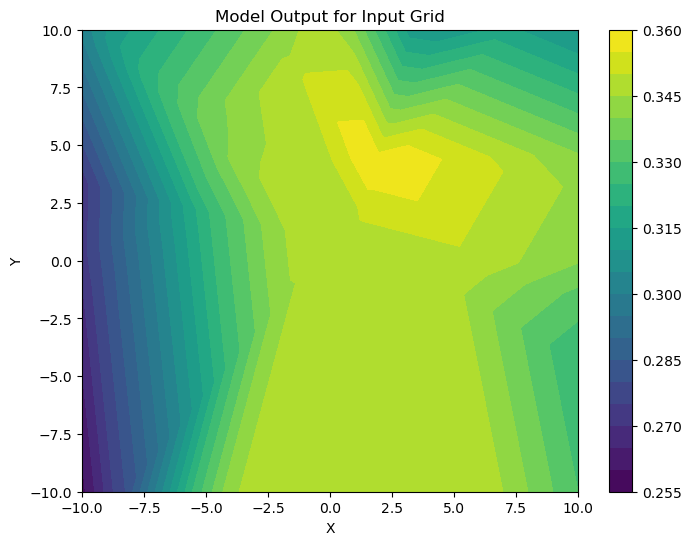

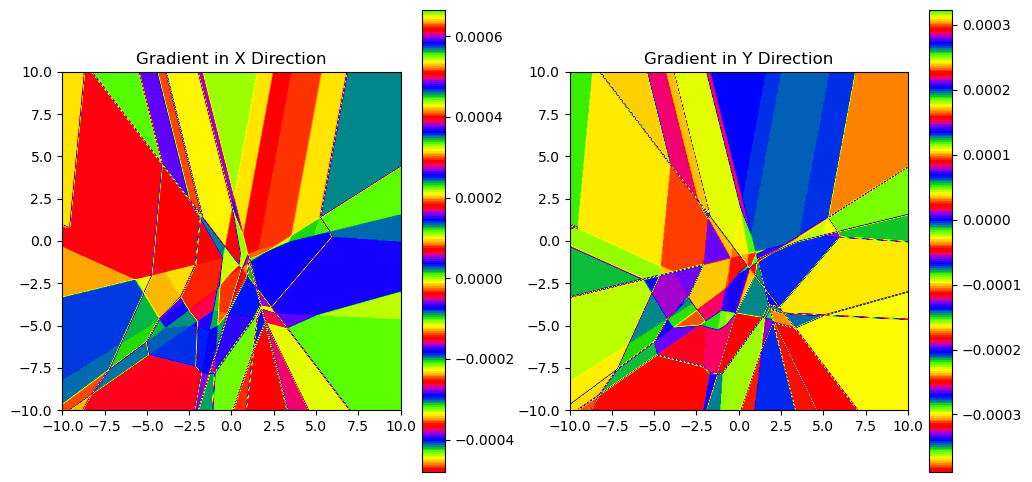

In [79]:
class DeeperNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeeperNN, self).__init__()
        
        self.hidden0 = nn.Linear(input_size, hidden_size) 
        self.hiddeni = nn.Linear(hidden_size, hidden_size)  
        self.output = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        x = torch.relu(self.hidden0(x)) 
        x = torch.relu(self.hiddeni(x))
        x = torch.relu(self.hiddeni(x))
        x = torch.relu(self.hiddeni(x))
        x = self.output(x) 
        return x

input_size = 2  
hidden_size = 5 
output_size = 1

model = DeeperNN(input_size, hidden_size, output_size)


x_range = np.linspace(-10, 10, 500)
y_range = np.linspace(-10, 10, 500)


xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T  # Stack them into 2D input for the model

grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

with torch.no_grad():  # No need to track gradients for this forward pass
    output = model(grid_tensor)

output = output.detach().numpy().reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, output, 20, cmap='viridis')
plt.colorbar()
plt.title('Model Output for Input Grid')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


grad_x, grad_y = np.gradient(output, axis=(1, 0))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(grad_x, cmap='prism', extent=[-10, 10, -10, 10])
plt.colorbar()
plt.title('Gradient in X Direction')

plt.subplot(1, 2, 2)
plt.imshow(grad_y, cmap='prism', extent=[-10, 10, -10, 10])
plt.colorbar()
plt.title('Gradient in Y Direction')

plt.show()

The output seems more complex than the one of the shallow network which is recocnizable from the more complex shapes.

## 5 Bonus: Number of linear regions
Formula for number of regions:
$$
R(n) = 1 +\frac{n(n+1)}{2}
$$

The derivation follows from the reasioning that each neuron with relu activation divides the space into two parts. 